# Libraryes 
Download all the library needed to execution of the notebook

In [151]:
import pandas as pd
import numpy as np
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.PDB.PDBParser import PDBParser
import matplotlib.pyplot as plt
import os
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa, PDBIO, NeighborSearch,Selection
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator
import numpy as np
import math
import matplotlib
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
from RamachanDraw import phi_psi
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy
from Bio.SeqUtils import seq1

# Protein download form PDB
This is the protein to analyze '2lea_A' download the assigned PDB structure and consider only standard (non-hetero) residues of the specified chain (<PDB ID>_<chain ID>). 

Calculate the contact map (question 1) and the conformational energy (questions 2 and 3) as described in the IUPRED paper. 

The M and P matrices are available from the iupred_data.py. The smoothed energy is the moving average of the raw energy over a window of 21 residues (±10 residues around the current position).

In [152]:
path = "./home/Documents/Structural-Bioinformatics"
id_protein, chain = ['2lea', 'A' ]
parser = PDBParser(QUIET=True)
# if the file does not exist, it will be downloaded
if os.path.exists(path + "/pdb/pdb{}.ent".format(id_protein.lower())) is True:
  path_pdb = path + "/pdb/pdb{}.ent".format(id_protein.lower())
else:
  pdbl = PDBList()
  path_pdb = pdbl.retrieve_pdb_file(id_protein, pdir=path + "/pdb", file_format="pdb")
structure = parser.get_structure(id_protein, path_pdb)
new_structure = structure.copy()

if os.path.exists(path +'/figures_mid_term2') is False:
  os.mkdir(path +'/figures_mid_term2') 

# Defain main function to use

In [153]:
def get_distance_matrix(atoms, seq_sep=6):
  """
  Calculate a distance matrix considering only 
  CA atoms and a minimum sequence separation.  
  Return a Numpy array
  """
  distances = []
  for atom1 in atoms:
    row = []
    for atom2 in atoms:
      # Check sequence separation
      # if abs(atom1.id[1] - atom2.id[1]) >= seq_sep:
      if abs(atoms.index(atom1) - atoms.index(atom2)) >= seq_sep:
        row.append(atom1 - atom2)
      else:
        row.append(None) # For atoms not respecting sequence separation
    distances.append(row)
  return np.array(distances, dtype=float)

In [154]:
def get_contact_map(atoms, threshold=3.5, seq_sep=2):

  # Calculate contacts
  ns = NeighborSearch(atoms)

  # Init a empty matrix
  contact_map_nb = np.zeros((len(atoms), len(atoms)))

  # "search_all" returns the list of atoms in contact based on a distance cutoff
  # level="R" returns pairs of residues instead of atoms
  for residues1, residues2 in ns.search_all(threshold, 'R'):
    if abs(residues1.id[1] - residues2.id[1]) >= seq_sep:
          contact_map_nb[residues1.id[1] , residues2.id[1]] = 1
          contact_map_nb[residues2.id[1], residues1.id[1]] = 1
  return contact_map_nb

#### Load the structure

In [155]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(id_protein, pdir=path + '/pdbs', file_format='pdb')
structure = PDBParser(QUIET=True).get_structure(id_protein, path + "/pdbs/pdb{}.ent".format(id_protein))

Structure exists: './home/Documents/Structural-Bioinformatics/pdbs/pdb2lea.ent' 


#### Select the atoms

In [156]:
selected_atoms = [residue['CA'] for residue in structure[0][chain] if residue.id[0] == " "]


#### Contacts calculated with Neighbours Search

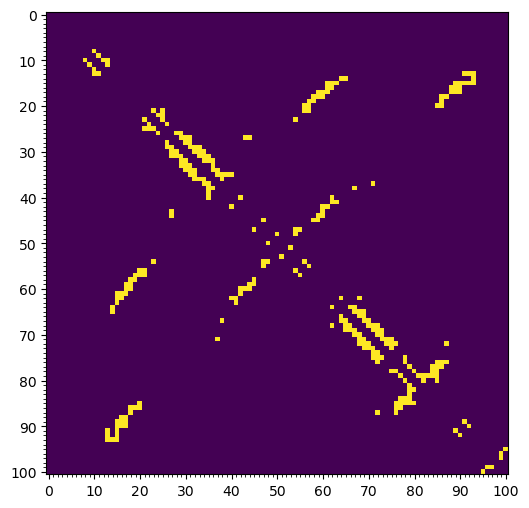

In [157]:
contact_map_nb = get_contact_map(selected_atoms, threshold=6, seq_sep=2)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map_nb)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures_mid_term2/ca_contacts_nb{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

#### Exact Energy
Calculate the exact energy of each residue based on the weighted contribution of its contacts
(as calculated above) and plot the raw and smoothed energy for each residue on the same figure.
Use the M matrix to calculate the contact energy

# TODO check waights and energy
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5734386/

In [158]:
execfile("./iupred_data.py")
m_matrix = np.array(m_matrix)
p_matrix = np.array(p_matrix)


In [159]:
def iupred(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''

    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix
    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size)
        end_before = max(0, i - sequence_separation)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]
        print(i, aa_index, aa_list[aa_index], len(indices), len(indices_local), start_before, end_before, start_after, end_after)

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1
        print(row)

        # calculate AA frequency
        row = row / len(indices_local)  
        print(row)

        # calculate energy
        row = row * p_matrix[aa_index, ]  
        print(row)

        aa_energy = np.sum(row)
        print(i, seq[i], aa_energy)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

0 10 M 101 98 0 0 2 100
[ 6  0 12  5  4  8  3  1  4  5  4  1  7  1 14  4  5  8  0  6]
[0.06122449 0.         0.12244898 0.05102041 0.04081633 0.08163265
 0.03061224 0.01020408 0.04081633 0.05102041 0.04081633 0.01020408
 0.07142857 0.01020408 0.14285714 0.04081633 0.05102041 0.08163265
 0.         0.06122449]
[-0.12734694  0.          0.07469388  0.12908163 -0.21795918 -0.04244898
 -0.02295918 -0.03693878  0.06571429 -0.14693878 -0.26489796  0.00214286
  0.05357143  0.01938776  0.29857143  0.05673469  0.03214286 -0.21142857
 -0.         -0.59571429]
0 M -0.9345918367346939
1 15 S 101 97 0 0 3 100
[ 6  0 12  5  4  8  3  1  4  5  4  1  7  1 14  4  5  8  0  5]
[0.06185567 0.         0.12371134 0.05154639 0.04123711 0.08247423
 0.03092784 0.01030928 0.04123711 0.05154639 0.04123711 0.01030928
 0.07216495 0.01030928 0.1443299  0.04123711 0.05154639 0.08247423
 0.         0.05154639]
[-0.00494845 -0.          0.11257732  0.04175258 -0.09154639  0.0585567
  0.02536082 -0.00154639  0.00783505 

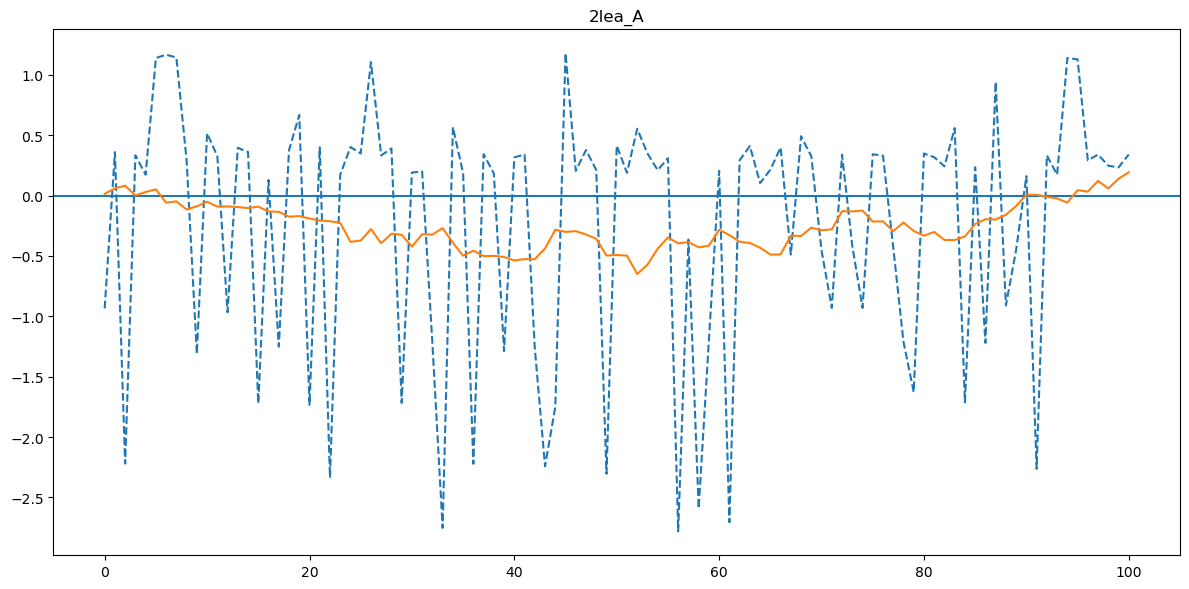

In [160]:
residues = [residue for residue in structure[0][chain] if residue.id[0] == " "]
seq = "".join([seq1(residue.get_resname()) for residue in residues])
pred, pred_smooth = iupred(seq)
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("{}_{}".format(id_protein, chain))
ax.axhline()
ax.plot(np.arange(len(seq)), pred, ls='--')
ax.plot(np.arange(len(seq)), pred_smooth, ls='-')
plt.tight_layout()  # Remove figure padding
plt.savefig(path + '/figures_mid_term2/iupred_{}_{}.png'.format(id_protein, chain), dpi=300, bbox_inches='tight')


Calculate the estimated energy of each residue based on the weighted contribution of the
frequency of neighboring amino acids in the sequence and plot the raw and smoothed energy
for each residue on the same figure. Use the P matrix to calculate the estimated energy.
Neighboring residues are those 2-100 residues apart from the current position.
$$E_{i}^p = \sum_{j=1}^{20} M_{ij} c_{j}^p$$

In [ ]:
E